## Deep Learning Final Project

- pretrained CLIP을 Dog Emotion 데이터에 대해 fine tuning진행.
최적의 parameter를 찾도록 노력



- prompt engineering에 따른 성능도 확인하기
### student id : 2020250012
### student name: 나지혜

## Data load

In [1]:
!pip install tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install kaggle --upgrade

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-btufpu9t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-btufpu9t
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "jeehyenaa"
os.environ['KAGGLE_KEY'] = "321d96dcbf40ba979d91fc5d290d687d" # Enter your Kaggle key here


# Dog Emotion Dataset
os.system('kaggle datasets download -d danielshanbalico/dog-emotion')

0

In [3]:
import zipfile
import os

# 압축 파일 경로
zip_path = 'dog-emotion.zip' # 다운로드한 zip 파일의 경로
extract_path = 'dog_emotion' # 압축을 풀 폴더 경로

# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축 해제 완료: {extract_path}")

압축 해제 완료: dog_emotion


In [4]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
import os
import pandas as pd
import numpy as np
import cv2
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Preprocessing

ref: https://www.kaggle.com/code/crn4tww/dog-emotions-classifier

In [5]:
# 데이터셋 경로 설정
data_path = 'dog_emotion/Dog Emotion/' # 여기서는 압축 해제된 폴더 경로로 설정

class_names = sorted(os.listdir(data_path))
# remove labels.csv because it's not a class
class_names.remove('labels.csv')
num_classes = len(class_names)

img_size = (224, 224, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')

4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (224, 224, 3)


In [6]:
images = []
labels = []
labels_df = pd.read_csv('dog_emotion/Dog Emotion/labels.csv')

print('\n\nlabels dataframe: \n', labels_df.head())

for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(data_path + image[2] + '/' + image[1], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))

    # 원-핫 인코딩 대신 클래스 인덱스를 직접 사용
    label = class_names.index(image[2])
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')




labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed

labels shape: (4000,)
images shape: (4000, 224, 224, 3)


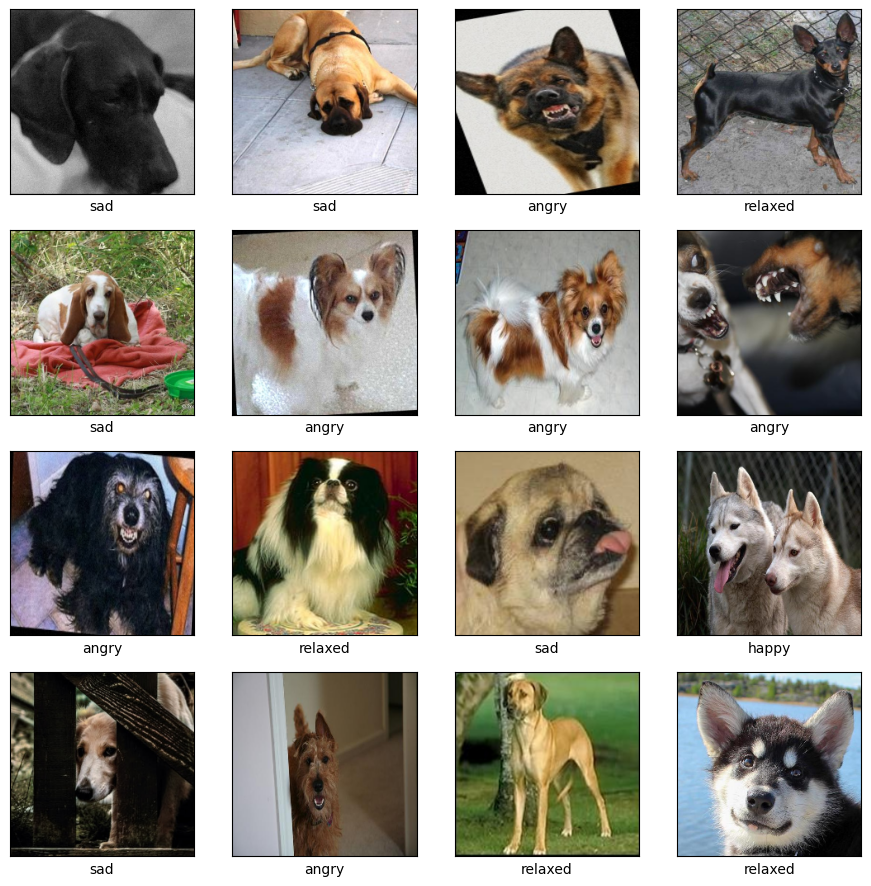

In [7]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[labels[i]])

plt.show()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (3200, 224, 224, 3)
train labels shape: (3200,)

validation images shape: (800, 224, 224, 3)
validation labels shape: (800,)



In [9]:
import numpy as np

# y_train 및 y_val에서 고유한 요소 및 그 빈도수 계산
unique, counts = np.unique(y_train, return_counts=True)
train_distribution = dict(zip(unique, counts))

unique, counts = np.unique(y_val, return_counts=True)
val_distribution = dict(zip(unique, counts))

print("Training set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)

Training set distribution: {0: 811, 1: 799, 2: 794, 3: 796}
Validation set distribution: {0: 189, 1: 201, 2: 206, 3: 204}


## Fine tuning

In [10]:
# CLIP 모델 로드
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [11]:
# emotion_folders = ['angry', 'happy', 'relaxed', 'sad']

In [12]:
class DogEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, preprocess):
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 이미지 전처리
        image = self.preprocess(Image.fromarray(self.images[idx]).convert("RGB"))
        # 클래스 인덱스 반환
        label = self.labels[idx]

        return image, label

# 데이터셋 및 데이터로더 초기화
train_dataset = DogEmotionDataset(X_train, y_train, preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 첫 번째 배치의 형식 확인
for images, texts in train_dataloader:
    print("이미지 형식:", images.shape)
    print("텍스트 형식:", texts.shape)
    break  # 첫 번째 배치만 확인하고 루프 종료

# 이미지 형식: torch.Size([128, 3, 224, 224])
# 텍스트 형식: torch.Size([128, 77]) 77은 텍스트 시퀀스의 길이.
# (CLIP에서 사용하는 크기로, PNEUMONIA 외의 부분들은 알아서 padding이 됨)

이미지 형식: torch.Size([128, 3, 224, 224])
텍스트 형식: torch.Size([128])


Epoch 49/50, Loss: 4.8125: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


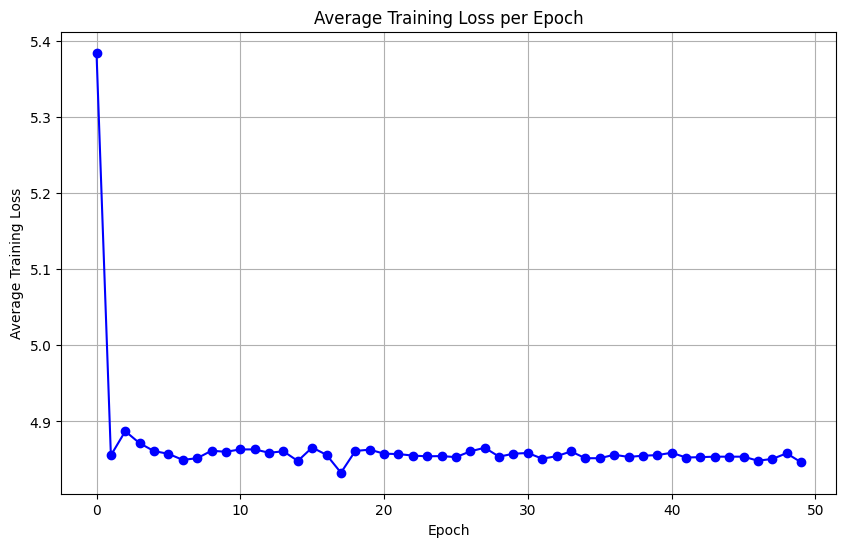

In [13]:
# 모델의 파라미터를 FP32 형식으로 변환하는 함수
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# 옵티마이저 준비
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01) # 원래는 weight dacay 0.2였음.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.001)
# 손실 함수 지정
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# 에폭에 따른 loss 저장
epoch_avg_losses = []

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss_sum = 0.0
    num_batches = 0
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for images, labels in pbar:
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)  # DataLoader로부터 반환된 실제 클래스 인덱스

        # 실제 클래스 이름을 사용하여 텍스트 토큰화
        texts = clip.tokenize([class_names[label] for label in labels.cpu().numpy()]).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # 실제 클래스 인덱스를 나타내는 ground_truth 생성
        ground_truth = labels

        # 손실 계산
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        # Backward pass
        total_loss.backward()
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)  # CLIP 모델의 가중치를 업데이트

        epoch_loss_sum += total_loss.item()
        num_batches += 1

        # tqdm 업데이트
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

    epoch_avg_loss = epoch_loss_sum / num_batches
    epoch_avg_losses.append(epoch_avg_loss)


plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_avg_losses, marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Average Training Loss per Epoch')
plt.grid(True)
plt.show()


In [14]:
# # Validation 데이터셋 준비
# val_dataset = DogEmotionDataset(X_val, y_val, preprocess)
# val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# def evaluate_model(model, dataloader, device):
#     model.eval()  # 모델을 평가 모드로 설정
#     total = 0
#     correct = 0

#     with torch.no_grad():  # 그래디언트 계산 비활성화
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # 텍스트 토큰화 및 장치 이동
#             texts = clip.tokenize([class_names[label] for label in labels.cpu().numpy()]).to(device)

#             # Forward pass
#             logits_per_image, _ = model(images, texts)
#             predictions = logits_per_image.argmax(dim=1)

#             # 정확도 계산
#             correct += (predictions == labels).sum().item()
#             total += labels.size(0)

#     accuracy = correct / total
#     return accuracy


# # Validation 데이터셋을 사용하여 모델 평가
# val_accuracy = evaluate_model(model, val_dataloader, device)
# print(f"Validation Accuracy: {val_accuracy:.4f}")

In [22]:
# Validation 데이터셋 준비
val_dataset = DogEmotionDataset(X_val, y_val, preprocess)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)


import torch.nn.functional as F


def evaluate_model_with_prompts(model, dataloader, class_names, prompts, device):
    model.eval()  # 모델을 평가 모드로 설정
    prompt_accuracies = {prompt: {'correct': 0, 'total': 0} for prompt in prompts}

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            for prompt in prompts:
                # 텍스트 토큰화 및 장치 이동
                texts = clip.tokenize([prompt.format(class_names[label]) for label in labels.cpu().numpy()]).to(device)

                # Forward pass
                logits_per_image, _ = model(images, texts)

                # logits를 softmax 함수를 사용하여 확률로 변환
                probabilities = F.softmax(logits_per_image, dim=1)
                # 가장 높은 확률을 가진 클래스를 예측값으로 선택
                predictions = probabilities.argmax(dim=1)
                # print(predictions)
                # 정확도 계산
                correct = (predictions == labels).sum().item()
                prompt_accuracies[prompt]['correct'] += correct
                prompt_accuracies[prompt]['total'] += labels.size(0)

    # 각 prompt에 대한 정확도 계산
    for prompt in prompts:
        accuracy = prompt_accuracies[prompt]['correct'] / prompt_accuracies[prompt]['total']
        prompt_accuracies[prompt]['accuracy'] = accuracy

    return prompt_accuracies

# 사용할 prompt 리스트
prompts = [
    "{}",
    "a photo of a {}",
    "a photo of a {} dog",
    "This dog looks {}",
    "imagine a {} dog"
]

# Validation 데이터셋을 사용하여 모델 평가 (prompt 별로)
prompt_accuracies = evaluate_model_with_prompts(model, val_dataloader, class_names, prompts, device)

# 각 prompt의 정확도 출력
for prompt, data in prompt_accuracies.items():
    print(f"Accuracy for prompt '{prompt}': {data['accuracy']:.4f}")

# CLIP모델의 출력이 class10개에 맞춰져 있어서 이러한 문제가 발생하는 듯! prediction의 범위가 0~ 10이다.

Accuracy for prompt '{}': 0.1562
Accuracy for prompt 'a photo of a {}': 0.1600
Accuracy for prompt 'a photo of a {} dog': 0.2137
Accuracy for prompt 'This dog looks {}': 0.2238
Accuracy for prompt 'imagine a {} dog': 0.1812


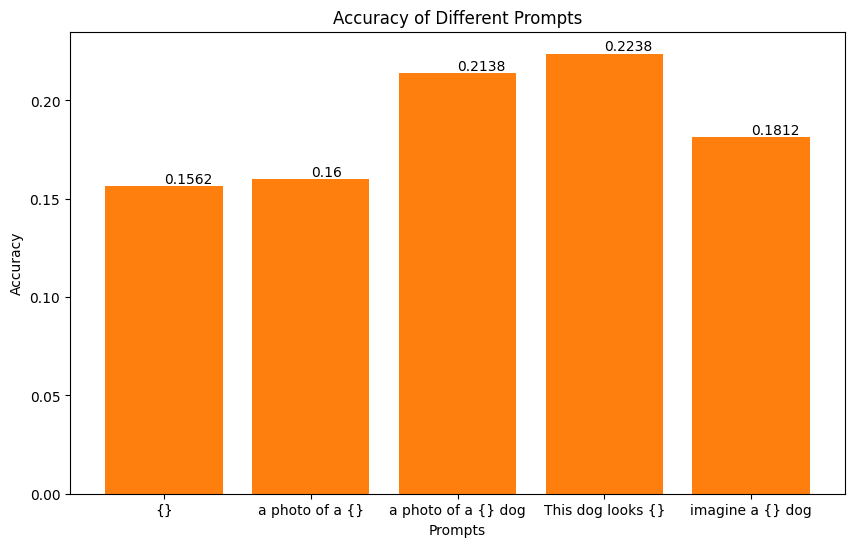

In [25]:
# bar chart로 accuracy 시각화
prompt_list = list(prompt_accuracies.keys())
accuracy_list = [prompt_accuracies[prompt]['accuracy'] for prompt in prompt_list]

plt.figure(figsize=(10, 6))
plt.bar(prompt_list, accuracy_list)
plt.xlabel('Prompts')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Prompts')

bars = plt.bar(prompt_list, accuracy_list)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # round(yval, 4)는 정확도를 소수점 네 자리까지 표시
plt.show()

## 시각화

In [17]:
# epoch에 따른 train loss와 test loss plot
# 보고서에 쓸 main figure 있어야 함

## Zero-shot Transfer 시의 성능 확인

In [18]:
# def evaluate_zero_shot(model, preprocess, images, labels, class_names, device):
#     model.eval()
#     total = 0
#     correct = 0

#     with torch.no_grad():
#         for img, label in zip(images, labels):
#             # 이미지 전처리
#             image = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)

#             # 모든 클래스에 대한 텍스트 설명 생성
#             text_inputs = torch.cat([clip.tokenize(f"The Dog in the picture is {c}") for c in class_names]).to(device)

#             # Forward pass
#             image_features = model.encode_image(image)
#             text_features = model.encode_text(text_inputs)

#             # 유사도 계산 및 예측
#             logits = (image_features @ text_features.T).softmax(dim=-1)
#             pred = logits.argmax(dim=-1).cpu().numpy()

#             # 실제 레이블 인덱스 계산
#             ground_truth = np.argmax(label)

#             # 정확도 계산
#             correct += (pred == ground_truth).sum()
#             total += 1

#     return correct / total

# # 제로샷 성능 평가
# zero_shot_accuracy = evaluate_zero_shot(model, preprocess, X_val, y_val, class_names, device)
# print(f"Zero-shot Accuracy: {zero_shot_accuracy:.4f}")


In [19]:
# 성능 비교할 baseline 설정